In [21]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import sys
import progressbar

In [22]:
file_path = '/home/logan_20/kitti_slam/dataset/sequences/00/image_0' # Path of the dataset
left_images=os.listdir(file_path) # To store the images in a list
type(left_images) # Datatype of the image sequence directory

list

In [23]:
left_images=os.listdir(file_path) # left_images is the list where the images are being stored
left_images.sort() # Sorting the list to preserve the order of the sequence as it is in the original folder
left_images[:5] # Displaying the first 5 images in the list

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png']

In [24]:
len(left_images) # Length of the frames

4541

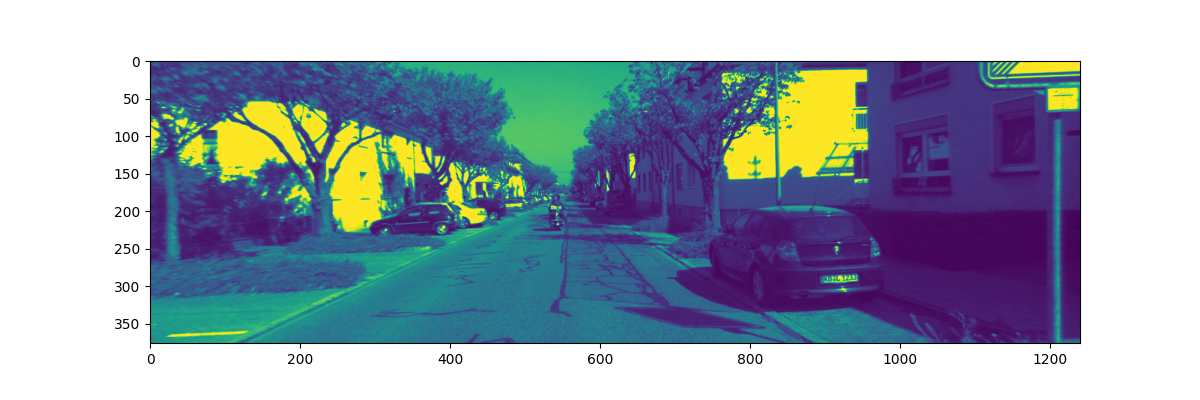

In [25]:
first_image=cv2.imread(os.path.join(file_path, left_images[0]), 0) # Using os.path.join to combine the path with the first image in the list and 0 is used as a flag to convert into grayscale
plt.figure(figsize=(12,4))
plt.imshow(first_image) # Displaying the first image in the list

In [26]:
first_image.shape # Shape of the image pixelwise

(376, 1241)

In [27]:
file_path='/home/logan_20/kitti_slam/dataset/sequences/00/' # File path for the velodyne data
velodyne_files=os.listdir(file_path+'velodyne') # Converting the velodyne binaries into a list
velodyne_files.sort() # Preserving the order of the files
velodyne_files[:5] # Displaying first 5 names of the velodyne dataset

['000000.bin', '000001.bin', '000002.bin', '000003.bin', '000004.bin']

In [28]:
pointcloud=np.fromfile(file_path+'velodyne/'+velodyne_files[0], dtype=np.float32)

In [29]:
type(pointcloud)

numpy.ndarray

In [30]:
pointcloud.shape

(498672,)

In [31]:
pointcloud=pointcloud.reshape(-1,4)
print(pointcloud.shape)
print(pointcloud.dtype)

(124668, 4)
float32


In [32]:
%matplotlib widget

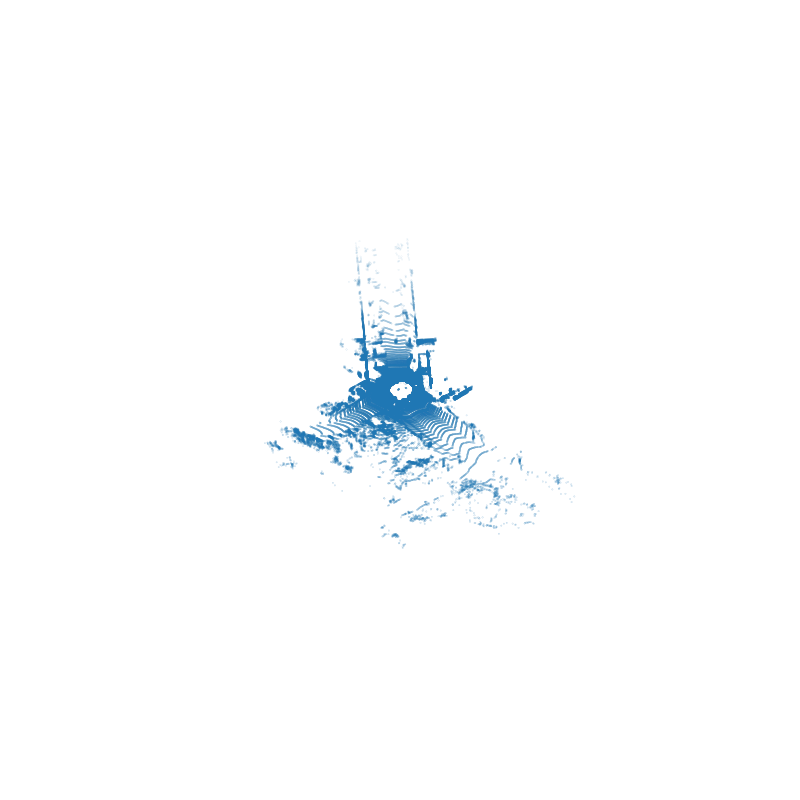

In [33]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111, projection='3d')

ys=pointcloud[:,1]#[::20]
xs=pointcloud[:,0]#[::20]
zs=pointcloud[:,2]#[::20]

# Plot for the point cloud and refer to the readme file for velodyne data to understand it more
# ax.plot(xs,ys,zs)
# ax.scatter(xs,ys,zs)
ax.set_box_aspect((np.ptp(xs),np.ptp(ys),np.ptp(zs)))
ax.scatter(xs,ys,zs,s=0.01)
ax.grid(False)
ax.axis('off')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=40,azim=180) # Direction in which the car is facing

In [34]:
calib=pd.read_csv('dataset/calib_sequences/00/calib.txt', delimiter=' ', header=None, index_col=0)
Tr=np.array(calib.iloc[4]).reshape(3,4)
print(Tr)

[[ 4.27680239e-04 -9.99967248e-01 -8.08449168e-03 -1.19845993e-02]
 [-7.21062651e-03  8.08119847e-03 -9.99941316e-01 -5.40398473e-02]
 [ 9.99973865e-01  4.85948581e-04 -7.20693369e-03 -2.92196865e-01]]


In [35]:
lidar_dir='dataset/velodyne_sequences/00/'
#/home/logan_20/kitti_slam/dataset/velodyne_sequences/00/velodyne
lidar_path=lidar_dir+'velodyne/'
lidar_path
velodyne_files=os.listdir(lidar_dir+'velodyne')
velodyne_files.sort()
velodyne_files[:5]
# #pointcloud=np.fromfile(lidar_path+velodyne_files[i],dtype=np.float32).reshape((-1,4))
# lidar_path


['000000.bin', '000001.bin', '000002.bin', '000003.bin', '000004.bin']

In [36]:
class Dataset_Handler():
    
    def __init__(self, sequence, lidar=True, progress_bar=True, low_memory=True):
        
        self.lidar = lidar
        self.low_memory = low_memory
        
        self.seq_dir = '/home/logan_20/kitti_slam/dataset/sequences/{}/'.format(sequence)
        self.poses_dir = '/home/logan_20/kitti_slam/dataset/poses/{}.txt'.format(sequence)
        
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.left_image_files.sort()
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.right_image_files.sort()
        self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')
        self.velodyne_files.sort()
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        self.gt = np.zeros((self.num_frames, 3, 4))
        
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape(3,4)
        
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3, 4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3, 4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3, 4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3, 4))
        self.Tr = np.array(calib.loc['Tr:']).reshape((3, 4))
        
        if low_memory:
            self.reset_frames()
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[1], 0)
            if self.lidar:
                self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                    dtype=np.float32, count=-1).reshape((-1, 4))
            self.imheight = self.first_image_left.shape[0]
            self.imwidth = self.first_image_left.shape[1]
        
        else:
            self.images_left = []
            self.images_right = []
            self.pointclouds = []
            if progress_bar:
                bar = progressbar.ProgressBar(max_value=self.num_frames)
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left, 0))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right, 0))
                if self.lidar:
                    pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[i], 
                                            dtype=np.float32, count=-1).reshape((-1, 4))
                    self.pointclouds.append(pointcloud)
                if progress_bar:
                    bar.update(i+1)
                self.imheight = self.images_left[0].shape[0]
                self.imwidth = self.images_right[0].shape[1]
                    
            
    def reset_frames(self):
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

In [37]:
# handler=Dataset_Handler('00',low_memory=False)

In [38]:
handler2=Dataset_Handler('00')

In [39]:
# plt.imshow(handler.images_left[0])
%matplotlib inline

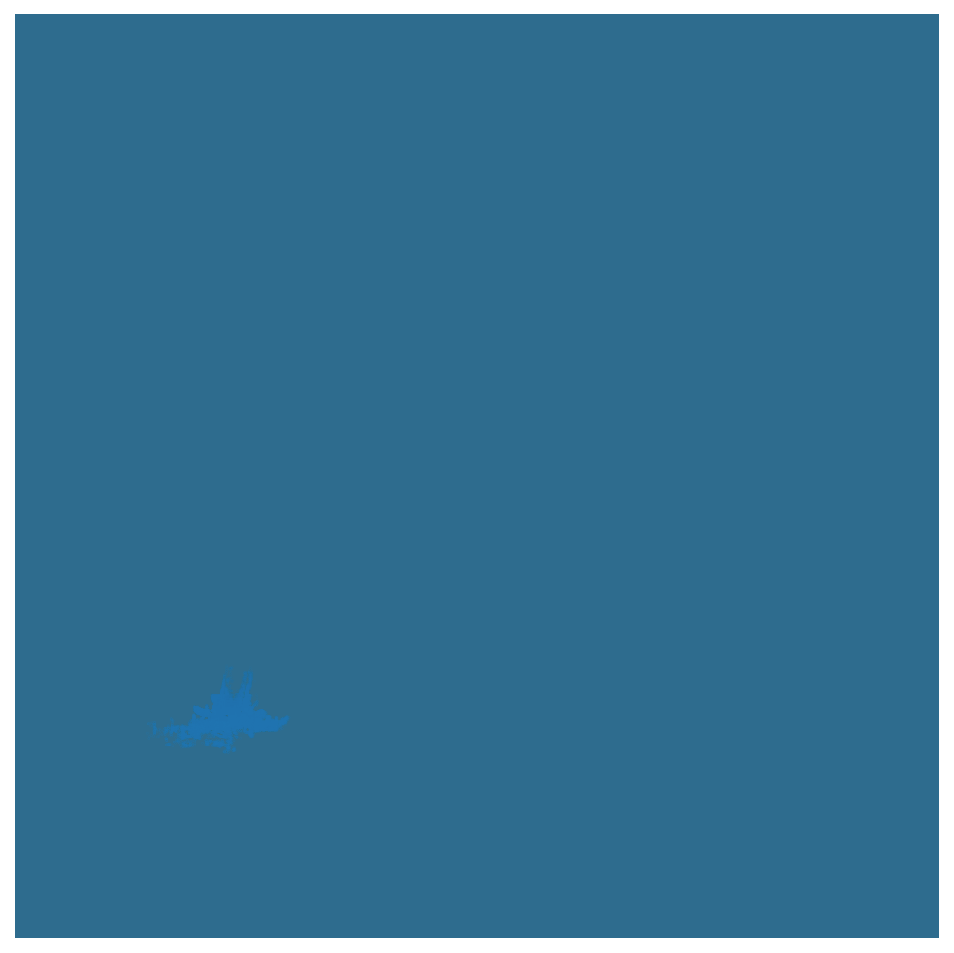

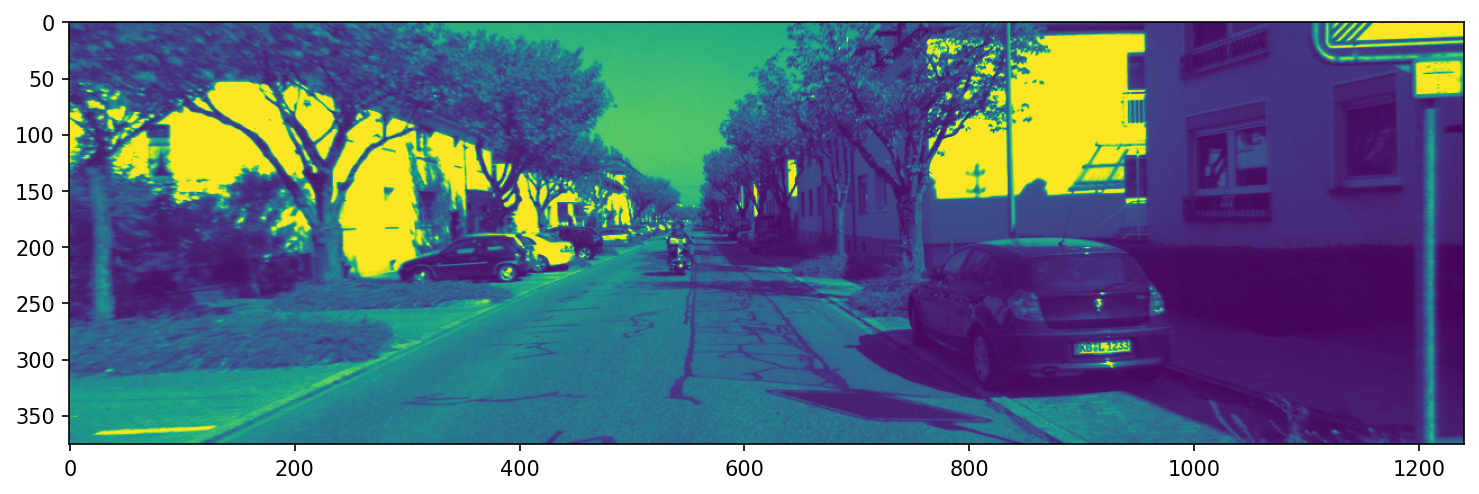

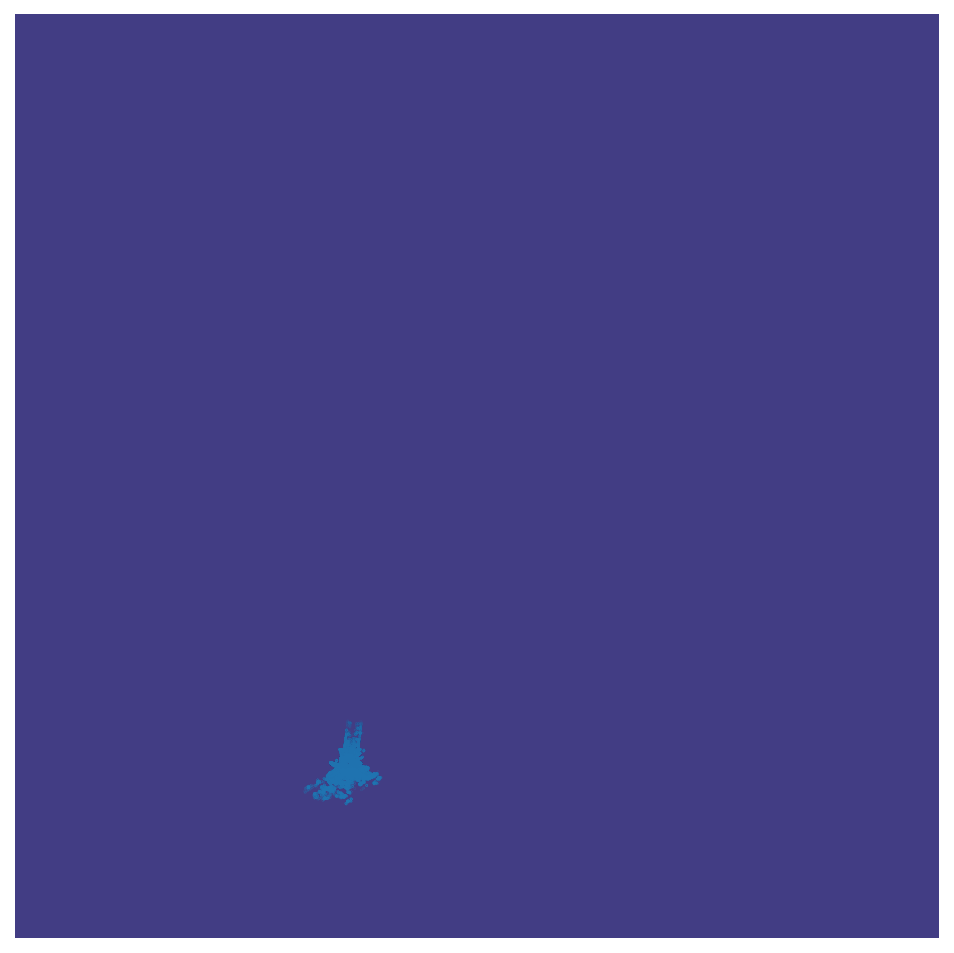

In [43]:
plt.imshow(next(handler2.images_left))
plt.show()